In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import warnings
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,  cross_validate
from sklearn.preprocessing import StandardScaler
import time
import sys, os
from sklearn.pipeline import make_pipeline


path = 'datasets/Dataset_2.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name="preproc")





INPUT DATA

In [7]:
X = (df.iloc[:,14:]).values
print(X.shape)
std_scaler = StandardScaler()

(2905, 530)


OUTPUT DATA

In [8]:
Y = (df.iloc[:,7]).values
print(Y.shape)

(2905,)


**NRMSEPiqr**

In [9]:


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)


SVR

0.25
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	50    	-0.354912	0.0206605  	-0.338864  	-0.431752  
1  	100   	-0.37256 	0.0305813  	-0.340425  	-0.48149   
2  	100   	-0.389852	0.0382908  	-0.342843  	-0.48149   
3  	100   	-0.394666	0.0376855  	-0.34058   	-0.48149   
4  	100   	-0.407667	0.0428924  	-0.346986  	-0.487185  
5  	100   	-0.41795 	0.0416261  	-0.347457  	-0.487185  
6  	100   	-0.439622	0.0734153  	-0.341122  	-0.632401  
7  	100   	-0.428165	0.065119   	-0.347072  	-0.632401  
8  	100   	-0.43946 	0.0756947  	-0.350664  	-0.632401  
9  	100   	-0.445333	0.0793691  	-0.343776  	-0.647759  
10 	100   	-0.463272	0.0826573  	-0.340588  	-0.647759  
11 	100   	-0.462876	0.0717158  	-0.35972   	-0.647759  
12 	100   	-0.482733	0.0866801  	-0.343938  	-0.647759  
13 	100   	-0.473368	0.0972144  	-0.340379  	-0.647759  
14 	100   	-0.502024	0.103132   	-0.340574  	-0.647759  
15 	100   	-0.526011	0.107929   	-0.340525  	-0.647759  
16 	100   	-0.543385	0.111

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.2s finished


0.5
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	50    	-0.383362	0.042738   	-0.364958  	-0.610115  
1  	100   	-0.397586	0.0427375  	-0.365064  	-0.610115  
2  	100   	-0.427156	0.0697636  	-0.365307  	-0.754464  
3  	100   	-0.436588	0.0453121  	-0.365093  	-0.610115  
4  	100   	-0.437861	0.0368273  	-0.365096  	-0.500329  
5  	100   	-0.439333	0.0432923  	-0.366422  	-0.500329  
6  	100   	-0.458883	0.0433034  	-0.373248  	-0.639897  
7  	100   	-0.458232	0.0419244  	-0.365135  	-0.639897  
8  	100   	-0.463735	0.066651   	-0.365128  	-0.639897  
9  	100   	-0.469239	0.0859129  	-0.365171  	-0.723192  
10 	100   	-0.482164	0.104235   	-0.365377  	-0.723192  
11 	100   	-0.479594	0.116261   	-0.365095  	-0.723192  
12 	100   	-0.486689	0.114056   	-0.366065  	-0.723192  
13 	100   	-0.497268	0.124469   	-0.365617  	-0.723192  
14 	100   	-0.569638	0.129855   	-0.369006  	-0.731121  
15 	100   	-0.581799	0.124158   	-0.366319  	-0.731138  
16 	100   	-0.593281	0.1401

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


0.75
gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	50    	-0.444617	0.0549976  	-0.424854  	-0.80794   
1  	100   	-0.465776	0.0379088  	-0.424989  	-0.588327  
2  	100   	-0.487293	0.0389201  	-0.425606  	-0.588327  
3  	100   	-0.497224	0.0366819  	-0.425155  	-0.547075  
4  	100   	-0.505319	0.0401855  	-0.427286  	-0.632346  
5  	100   	-0.504007	0.0599973  	-0.426406  	-0.777728  
6  	100   	-0.518957	0.0887248  	-0.430409  	-0.777728  
7  	100   	-0.536496	0.102529   	-0.430257  	-0.777728  
8  	100   	-0.582829	0.116589   	-0.442084  	-0.777728  
9  	100   	-0.590071	0.119242   	-0.426553  	-0.777728  
10 	100   	-0.621154	0.132581   	-0.429383  	-0.777728  
11 	100   	-0.651662	0.129545   	-0.42922   	-0.777728  
12 	100   	-0.658075	0.131699   	-0.426873  	-0.777728  
13 	100   	-0.665192	0.13893    	-0.427755  	-0.791686  
14 	100   	-0.656246	0.14551    	-0.425234  	-0.791686  
15 	100   	-0.613953	0.15976    	-0.426267  	-0.791686  
16 	100   	-0.602187	0.147

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.1s finished


╔════════════════╦══════════╦═════════════════════╦═════════════════════╦═══════════════════════════════╦═════════════════════════════╦═══════════════════╗
║   Test size(%) ║   Best C ║   Mean CV NRMSEPiqr ║   Var CV NRMSEPiqr) ║   Mean CV Training Time (sec) ║   Final training time (sec) ║   Final NRMSEPiqr ║
╠════════════════╬══════════╬═════════════════════╬═════════════════════╬═══════════════════════════════╬═════════════════════════════╬═══════════════════╣
║             25 ║  99.8893 ║            0.338599 ║         0.000561638 ║                     2.00469   ║                    14231.9  ║          0.350732 ║
║             50 ║  66.135  ║            0.364939 ║         0.00228304  ║                     0.616412  ║                     4845.95 ║          0.377766 ║
║             75 ║  71.5677 ║            0.424813 ║         0.00307312  ║                     0.0868194 ║                     1072.52 ║          0.406843 ║
╚════════════════╩══════════╩═════════════════════╩═════════════

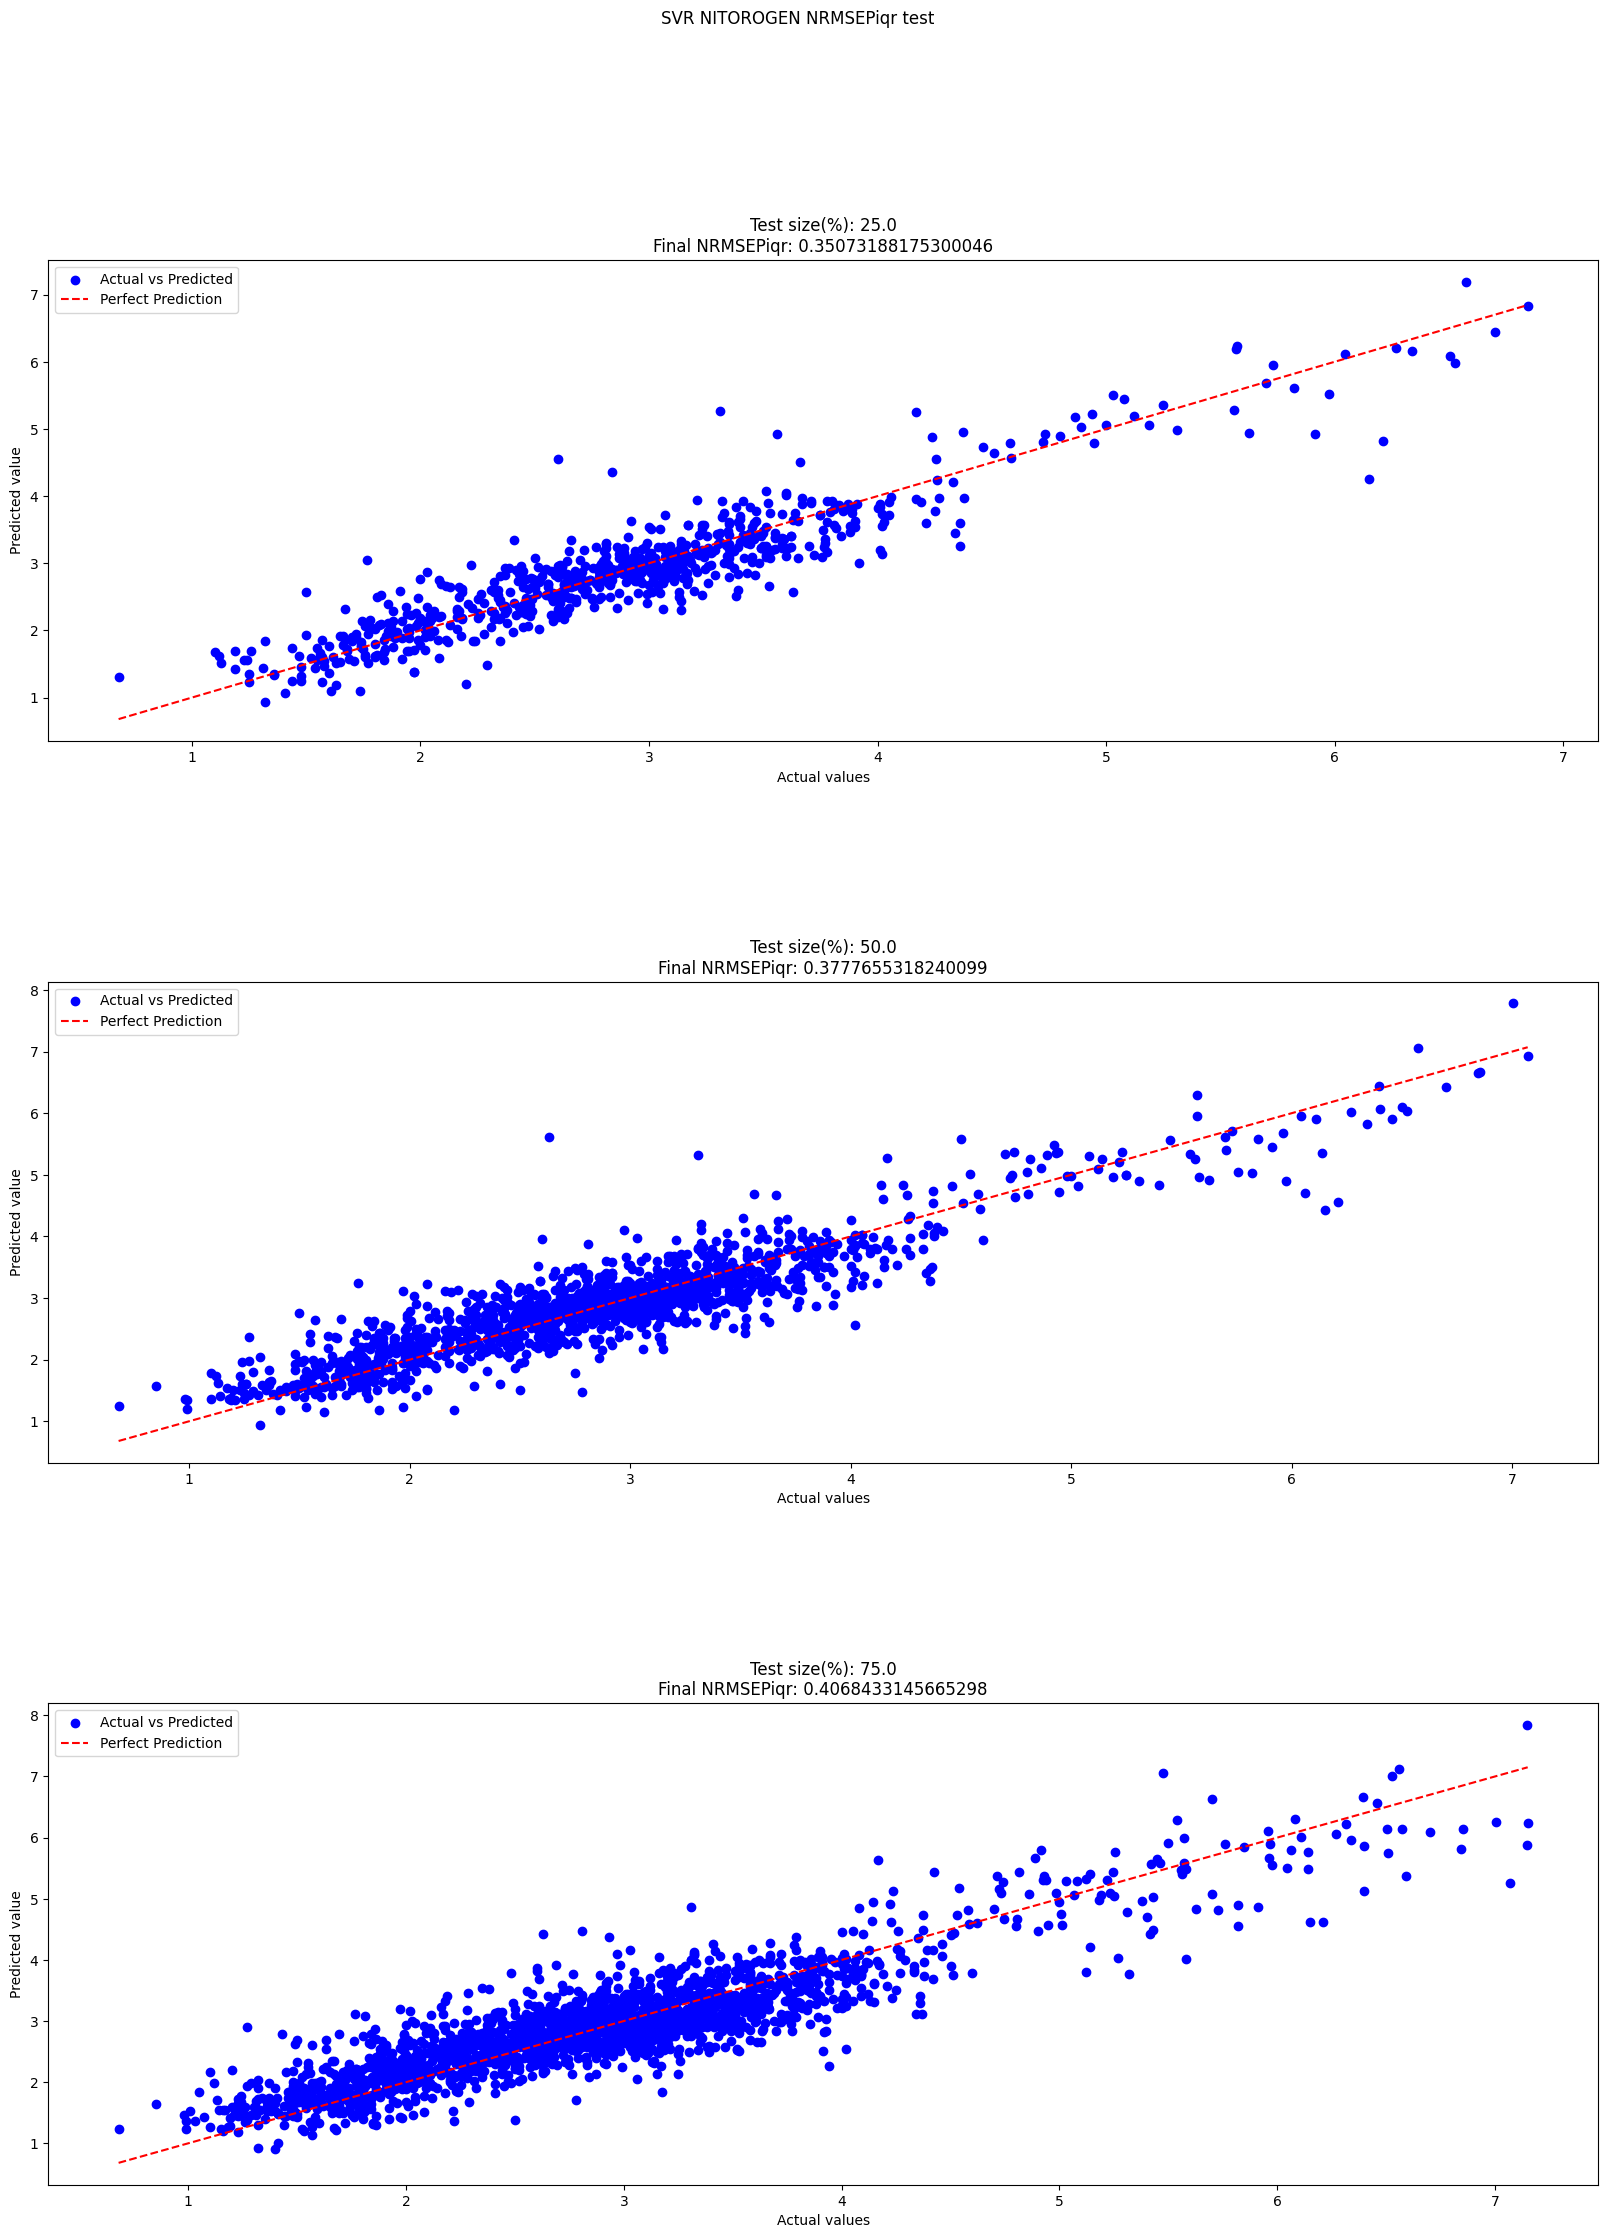

In [13]:

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 


np.random.seed(42)

ripartisions = [0.25,0.5,0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('SVR NITOROGEN NRMSEPiqr test' + "\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:
  
        NRMSEP = []

        print(ripartition)
    
        #Ripartition in training and test and
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=42)
        X_train= std_scaler.fit_transform(X_train)
        X_test= std_scaler.transform(X_test)
        param_grid = {'C': Continuous(1/100000,100)}
        elastic_reg_cd = SVR()
        sturges = int(1 + np.log(len(X_train)))   
        evolved_estimator = GASearchCV(estimator=elastic_reg_cd,
                              cv=sturges,
                              scoring=NRMSEPiqrscorer,
                              param_grid=param_grid,
                              n_jobs=-1,
                              verbose=True,
                              population_size=50,
                              generations=50,
                              criteria = "min")
    
        start_time = time.time()
        evolved_estimator.fit(X_train, Y_train)
        elapsed_time = (time.time() -start_time) #elapsed time in seconds
    
        best_model =  evolved_estimator.best_estimator_

        # Make predictions using the testing set
        Y_pred_svr =  best_model.predict(X_test)

         
        cv_scores = cross_validate(best_model, X_train, Y_train, cv=sturges, scoring=NRMSEPiqrscorer,n_jobs=-1, verbose=1)    
    

        results.append([str(ripartition *100 ),evolved_estimator.best_params_["C"],-np.mean(cv_scores['test_score']), np.var(cv_scores['test_score']),
                    np.mean(cv_scores['fit_time']), elapsed_time, NRMSEPiqr(Y_test, Y_pred_svr)])

    
        '''PLOT THE BEST MODELS'''
        axs[k].scatter(Y_test,Y_pred_svr, c='blue', label='Actual vs Predicted')
        axs[k].plot([min(Y_test), max(Y_test)],
                            [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
        axs[k].legend()
        axs[k].set_xlabel("Actual values")
        axs[k].set_ylabel("Predicted value")
        axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "Final NRMSEPiqr: " + str(results[k][6]) )
        k += 1

'''SHOW RESULTS'''

headers = ["Test size(%)", "Best C", "Mean CV NRMSEPiqr", "Var CV NRMSEPiqr)","Mean CV Training Time (sec)" ,"Final training time (sec)","Final NRMSEPiqr"]
print(tabulate(results, headers,  tablefmt="double_outline"))
